#### Import các thư viện cần thiết

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

#### Xác định phần cứng và cố định tham số ngẫu nhiên

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benckmark = False

SEED = 42
set_seed(SEED)

#### Tải bộ dữ liệu

In [3]:
train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data', 
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

#### Chia bộ dữ liệu train/val/test

In [4]:
train_ratio = 0.9
batch_size = 128
train_size = int(len(train_dataset) * train_ratio) 
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train size: {len(train_subset)}')
print(f'Validation size: {len(val_subset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 54000
Validation size: 6000
Test size: 10000


### Normalize Inside Network

#### Xây dựng mô hình MLP

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.hidden_dims = hidden_dims
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.BatchNorm1d(self.hidden_dims, device=device)(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.BatchNorm1d(self.hidden_dims, device=device)(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.BatchNorm1d(self.hidden_dims, device=device)(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.BatchNorm1d(self.hidden_dims, device=device)(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.BatchNorm1d(self.hidden_dims, device=device)(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.BatchNorm1d(self.hidden_dims, device=device)(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.BatchNorm1d(self.hidden_dims, device=device)(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out
    
input_dims = 784 # (28, 28)
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

#### Huấn luyện mô hình

In [6]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)
    
    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
        count += len(y_val)
    
    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 1.4887, Train_Acc: 0.6853, Validation Loss: 1.1183, Val_Acc: 0.7535
EPOCH 2/100, Train_Loss: 0.9355, Train_Acc: 0.7863, Validation Loss: 0.8182, Val_Acc: 0.7980
EPOCH 3/100, Train_Loss: 0.7270, Train_Acc: 0.8150, Validation Loss: 0.6794, Val_Acc: 0.8193
EPOCH 4/100, Train_Loss: 0.6197, Train_Acc: 0.8287, Validation Loss: 0.5975, Val_Acc: 0.8330
EPOCH 5/100, Train_Loss: 0.5552, Train_Acc: 0.8393, Validation Loss: 0.5503, Val_Acc: 0.8370
EPOCH 6/100, Train_Loss: 0.5103, Train_Acc: 0.8462, Validation Loss: 0.5152, Val_Acc: 0.8412
EPOCH 7/100, Train_Loss: 0.4783, Train_Acc: 0.8539, Validation Loss: 0.4884, Val_Acc: 0.8468
EPOCH 8/100, Train_Loss: 0.4530, Train_Acc: 0.8581, Validation Loss: 0.4707, Val_Acc: 0.8482
EPOCH 9/100, Train_Loss: 0.4343, Train_Acc: 0.8628, Validation Loss: 0.4575, Val_Acc: 0.8523
EPOCH 10/100, Train_Loss: 0.4174, Train_Acc: 0.8658, Validation Loss: 0.4361, Val_Acc: 0.8603
EPOCH 11/100, Train_Loss: 0.4038, Train_Acc: 0.8693, Validation Loss:

#### Trực quan hóa

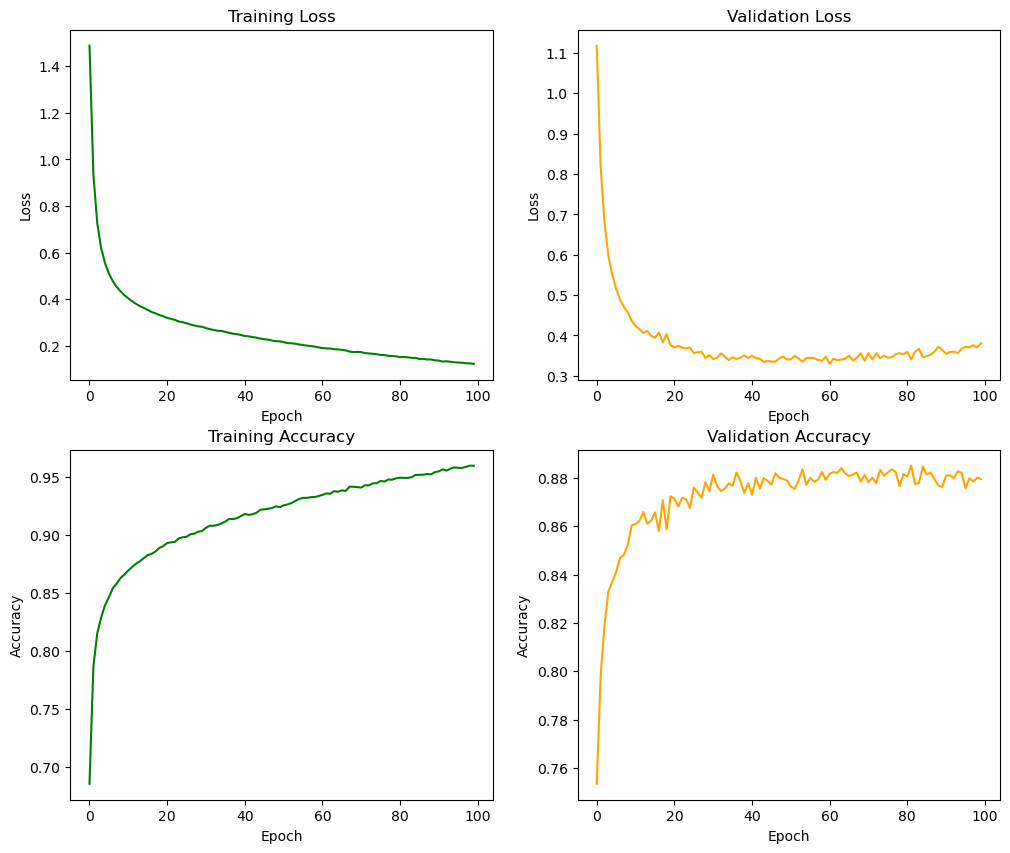

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

#### Đánh giá mô hình

In [8]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader: 
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.8741


### Customized Normalization Layer

#### Xây dựng mô hình MLP

In [9]:
class MyNormalization(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean) / std

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=10.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = MyNormalization()(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out
    
input_dims = 784 # (28, 28)
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

#### Huấn luyện mô hình

In [11]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)
    
    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
        count += len(y_val)
    
    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 58.4376, Train_Acc: 0.0961, Validation Loss: 34.6167, Val_Acc: 0.0902
EPOCH 2/100, Train_Loss: 23.3038, Train_Acc: 0.0844, Validation Loss: 15.6222, Val_Acc: 0.0900
EPOCH 3/100, Train_Loss: 12.8182, Train_Acc: 0.0709, Validation Loss: 10.6172, Val_Acc: 0.1328
EPOCH 4/100, Train_Loss: 8.0609, Train_Acc: 0.0785, Validation Loss: 5.7599, Val_Acc: 0.1003
EPOCH 5/100, Train_Loss: 3.5935, Train_Acc: 0.0750, Validation Loss: 2.3131, Val_Acc: 0.1127
EPOCH 6/100, Train_Loss: 2.3064, Train_Acc: 0.0771, Validation Loss: 2.3070, Val_Acc: 0.1222
EPOCH 7/100, Train_Loss: 2.3061, Train_Acc: 0.0827, Validation Loss: 2.3062, Val_Acc: 0.0830
EPOCH 8/100, Train_Loss: 2.3059, Train_Acc: 0.0871, Validation Loss: 2.3067, Val_Acc: 0.0612
EPOCH 9/100, Train_Loss: 2.3061, Train_Acc: 0.0794, Validation Loss: 2.3054, Val_Acc: 0.0900
EPOCH 10/100, Train_Loss: 2.3060, Train_Acc: 0.0880, Validation Loss: 2.3062, Val_Acc: 0.0833
EPOCH 11/100, Train_Loss: 2.3061, Train_Acc: 0.0796, Validation

#### Trực quan hóa

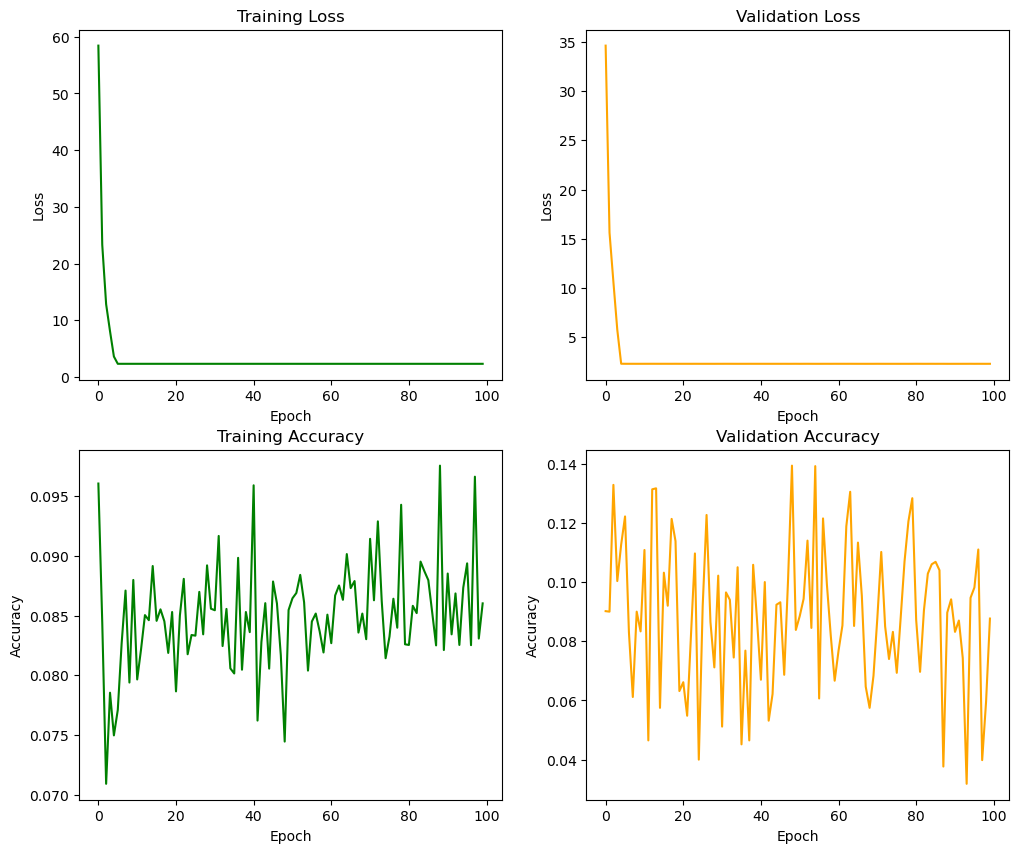

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

#### Đánh giá mô hình

In [13]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader: 
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.0845
